In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

from id01lib import id01h5
from id01lib.xrd.qconversion import scan_to_qspace_h5,qconvert_mgrid
from id01lib.xrd.geometries import ID01psic
from mayavi import mlab

%gui qt5

/users/zatterin/Envs/py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Sample and scans
fname = '/users/zatterin/Documents/beam/20170712_HC2912/data/hc2912.h5'
sample = 'E16095_furnace'
scan_no = 34

# Experimental parameters
det_distance =  0.422
cen_pix = [281.847,278.792] # x, y
nrj=8
nbins = (100,100,100)

# Open the h5 file
with h5py.File(fname) as h5f:
    
    # read / set offsets
    scan = h5f['/{0}/{1}.1'.format(sample,scan_no)]
    phi_off = h5f['/{0}/{1}.1/instrument/positioners/phi'.format(sample,scan_no)].value
    rhx_off = h5f['/{0}/{1}.1/instrument/positioners/rhx'.format(sample,scan_no)].value
    rhy_off = h5f['/{0}/{1}.1/instrument/positioners/rhy'.format(sample,scan_no)].value
    nu_off =  h5f['/{0}/{1}.1/instrument/positioners/nu'.format(sample,scan_no)].value
    ID01psic().usemotors = set(('eta', 'phi', 'nu', 'delta'))
    
    # set to corresponding offsets if needed
    ID01psic().set_offsets(eta=0, rhy=0, rhx=0.656, phi=1.994, nu=0)
    
    # convert to q space
    qx, qy, qz, gint = scan_to_qspace_h5(scan, 
                                         cen_pix=(cen_pix[1],cen_pix[0]), 
                                         distance=det_distance, 
                                         energy=8,
                                         nbins=nbins)

Selected /E16095_furnace/34.1
Offsets used: rhy = 0.0, rhz = 0.0, nu = 0.0, eta = 0.0, mu = 0.0, rhx = 0.656, phi = 1.994, delta = 0.0, 
Max. number of bins: 355, 532, 518
Using binning: (100, 100, 100)


In [3]:
qxx, qyy, qzz, i = qconvert_mgrid(qx, qy, qz, gint, 4.5)


Gridding with bins: (100, 100, 100)


Current problem: VTK's .x3d exporter (which is called upon by mlab) seems to fail to treat transparency info correctly. See:
* [This](http://fpavogt.github.io/x3d-pathway/index.html) for info on X3D / html implementation (astrophysics)
* And [this](https://github.com/enthought/mayavi/issues/485) issue on GitHub describing a similar problem.

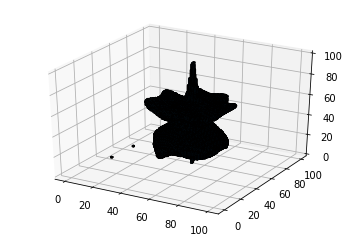

In [70]:
# attention this will take a while!
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')
t = (i>i.min())
ax.voxels(t,edgecolor='black')

plt.show()

## Some nice candidates

In [10]:
mlab.contour3d(i)

In [4]:
mlab.options.backend = 'simple' # 'envisage' for the full mayavi2 application to be launched.
# mlab.init_notebook(backend='png', local=False, width=1000, height=1000) # 'x3d' backend for inline interactivity

In [5]:
qxx, qyy, qzz, i = qconvert_mgrid(qx, qy, qz, gint, 4.5)

# project the int in various directions
a, b, c = i.sum(2), i.sum(1), i.sum(0)

# make a figure
mlab.clf()
fig = mlab.figure(size=(1000/2,1000/2), bgcolor=(1,1,1), fgcolor=(0,0,0))

# make limits for the q ranges
limits = [qx.min(), qx.max(), qy.min(), qy.max(), qz.min(), qz.max()]

# source the 2d projections
imga = mlab.pipeline.array2d_source(a)
imgb = mlab.pipeline.array2d_source(b)
imgc = mlab.pipeline.array2d_source(c)

# threshold them
n = 0.01
ta = mlab.pipeline.threshold(imga, low=a.min()+n)
tb = mlab.pipeline.threshold(imgb, low=b.min()+n)
tc = mlab.pipeline.threshold(imgc, low=c.min()+n)

# make them as surfaces and orient them
projz = mlab.pipeline.surface(ta, extent=[qx.min(), qx.max(), qy.min(), qy.max(), qz.min(), qz.min()])
projy = mlab.pipeline.surface(tb, extent=limits)
projx = mlab.pipeline.surface(tc, extent=limits)

# plot the 3d isosurface
surf = mlab.contour3d(qxx,qyy,qzz,i, contours=20, opacity=.8, transparent=False) 

# rotate the x and y projections
projy.actor.actor.orientation = [90, 0, 0] 
projy.actor.actor.position = [(qx.min()+qx.max())/2, qy.min(), (qz.min()+qz.max())/2]   
projy.actor.actor.scale = np.array([0.00286942,0.00286942,0.00286942])

projx.actor.actor.orientation = [90, 90, 0] 
projx.actor.actor.position = [qx.min(), (qy.min()+qy.max())/2, (qz.min()+qz.max())/2]   
projx.actor.actor.scale = np.array([0.00286942,0.00286942,0.00286942])

projz.actor.actor.scale = np.array([0.00286942,0.00286942,0.00286942])

# # Add axes
axes = mlab.axes(surf, extent=limits, nb_labels=3, xlabel='Qx', ylabel='Qy', zlabel='Qz')

# Tweak the appearance of the axes labels
axes.title_text_property.font_family = 'arial'
axes.label_text_property.font_family = 'arial'
axes.axes.font_factor = 1.6
axes.axes.label_format = '%2.2f'
# axes.title_text_property.font_size = 10
# axes.title_text_property.orientation = 0.0
axes.property.line_width = 4
axes.axes.corner_offset = 0.05
axes.label_text_property.orientation = 0
axes.label_text_property.italic = False
axes.label_text_property.bold = False

# # Tweak the camera view
mlab.view(azimuth=60, elevation=60, distance=1)
mlab.outline()

fig


Gridding with bins: (100, 100, 100)


In [51]:
mlab.options.backend = 'simple' # 'envisage' for the full mayavi2 application to be launched.
mlab.init_notebook(backend='png', local=False, width=1, height=1) # 'x3d' backend for inline interactivity

Notebook initialized with png backend.


In [6]:

qxx, qyy, qzz, i = qconvert_mgrid(qx, qy, qz, gint, 5)

# project the int in various directions
a, b, c = i.sum(2), i.sum(1), i.sum(0)

# make limits for the q ranges
limits = [qx.min(), qx.max(), qy.min(), qy.max(), qz.min(), qz.max()]

# number for the threshold
n=0.1

# make a figure
mlab.clf()
fig = mlab.figure(size=(1000/2,1000/2), bgcolor=(1,1,1), fgcolor=(0,0,0))
cmap = 'jet'

# load the 3d data
src = mlab.pipeline.scalar_field(i)

# extract VOIs 
voi = mlab.pipeline.extract_grid(src)
voi.trait_set(x_min=0.01, x_max=54, y_min=0.01, y_max=99.99, z_min=0.01, z_max=99.99)
voi2 = mlab.pipeline.extract_grid(src)
voi2.trait_set(x_min=0.01, x_max=99.99, y_min=0.01, y_max=54, z_min=0.01, z_max=99.99)

# Threshold the data and plot it on cut planes
thr = mlab.pipeline.threshold(src, low=i.min()+n)
cut_plane = mlab.pipeline.scalar_cut_plane(thr, plane_orientation='y_axes', colormap=cmap, vmin=1.25)
cut_plane2 = mlab.pipeline.scalar_cut_plane(thr, plane_orientation='x_axes', colormap=cmap, vmin=1.25)
cut_plane.implicit_plane.widget.enabled = False
cut_plane2.implicit_plane.widget.enabled = False

cut_plane.enable_contours = True
cut_plane.contour.filled_contours = True
cut_plane.contour.number_of_contours = 30

cut_plane2.enable_contours = True
cut_plane2.contour.filled_contours = True
cut_plane2.contour.number_of_contours = 30

# ## PROJECTIONS
# # source the 2d projections
# imga = mlab.pipeline.array2d_source(a)
# imgb = mlab.pipeline.array2d_source(b)
# imgc = mlab.pipeline.array2d_source(c)
# # threshold them
# n = 0.0001
# ta = mlab.pipeline.threshold(imga, low=a.min()+n)
# tb = mlab.pipeline.threshold(imgb, low=b.min()+n)
# tc = mlab.pipeline.threshold(imgc, low=c.min()+n)
# # make them as surfaces and orient them
# projz = mlab.pipeline.surface(ta, colormap=cmap)
# projy = mlab.pipeline.surface(tb, colormap=cmap)
# projx = mlab.pipeline.surface(tc, colormap=cmap)
# # rotate the x and y projections
# projy.actor.actor.orientation = [90, 0, 0] 
# projy.actor.actor.position = [50, 0 ,50]
# projx.actor.actor.orientation = [90, 90, 0] 
# projx.actor.actor.position = [0, 50 ,50] 
# projz.actor.actor.position = [50,50,0]

### PLOT
# plot the VOIs
iso1 = mlab.pipeline.iso_surface(voi, contours=[1.4453415313199742], colormap=cmap)
iso2 = mlab.pipeline.iso_surface(voi2, contours=[1.4453415313199742], colormap=cmap)
iso1.actor.property.interpolation = 'gouraud'
iso2.actor.property.interpolation = 'gouraud'
# Add axes
axes = mlab.axes(voi, ranges=limits, extent=[0,100,0,100,0,100], nb_labels=3, xlabel='Qx', ylabel='Qy', zlabel='Qz')
# Tweak the appearance of the axes labels
axes.title_text_property.font_family = 'arial'
axes.label_text_property.font_family = 'arial'
axes.axes.font_factor = 1.6
axes.axes.label_format = '%2.2f'
# axes.title_text_property.font_size = 10
# axes.title_text_property.orientation = 0.0
axes.property.line_width = 4
axes.axes.corner_offset = 0.05
axes.label_text_property.orientation = 0
axes.label_text_property.italic = False
axes.label_text_property.bold = False
# Tweak the camera view
mlab.view(azimuth=60, elevation=60, distance=360)
mlab.outline(extent=[0,100,0,100,0,100])

# Light tweaks
# camera_light2 = engine.scenes[0].scene.light_manager.lights[1]
# camera_light2.intensity = 1.0
# camera_light3 = engine.scenes[0].scene.light_manager.lights[2]
# camera_light3.intensity = 1.0
# camera_light3.elevation = 30
# camera_light3.azimuth = 60

mlab.colorbar()

fig


Gridding with bins: (100, 100, 100)


In [33]:
qxx, qyy, qzz, i = qconvert_mgrid(qx, qy, qz, gint, 6)


Gridding with bins: (100, 100, 100)


In [34]:
i.min(), i.max()

(0.39534153131997407, 6.395341531319974)

In [44]:
mlab.options.backend = 'simple' # 'envisage' for the full mayavi2 application to be launched.
mlab.init_notebook(backend='png', local=False, width=1, height=1) # 'x3d' backend for inline interactivity

Notebook initialized with png backend.


In [7]:
limits = [qx.min(), qx.max(), qy.min(), qy.max(), qz.min(), qz.max()]
n, m = 1, n*100

mlab.clf()
fig = mlab.figure(size=(1000/2,1000/2), bgcolor=(1,1,1), fgcolor=(0,0,0))
src = mlab.pipeline.scalar_field(i)

surf = mlab.pipeline.iso_surface(src, contours=[i.min()+0.1], opacity=0.4, color=(1,1,1))
surf.actor.actor.scale = [1,1,n]

cut1 = mlab.pipeline.scalar_cut_plane(src, plane_orientation='z_axes', vmin=i.min(), vmax=3, view_controls=False)
cut1.implicit_plane.plane.origin = [50,50,60]
cut1.actor.actor.scale = [1. , 1. , n]

cut2 = mlab.pipeline.scalar_cut_plane(src, plane_orientation='z_axes', vmin=i.min(), vmax=3, view_controls=False)
cut2.implicit_plane.plane.origin = [50,50,55]
cut2.actor.actor.scale = [1. , 1. , n]

cut3 = mlab.pipeline.scalar_cut_plane(src, plane_orientation='z_axes', vmin=i.min(), vmax=3, view_contx3drols=False)
cut3.implicit_plane.plane.origin = [50,50,30]
cut3.actor.actor.scale = [1. , 1. , n]

mlab.view(azimuth=70, elevation=68, distance=360)

# Add axes
axes = mlab.axes(src, ranges=limits, extent=[0,100,0,100,0,m], nb_labels=3, xlabel='Qx', ylabel='Qy', zlabel='Qz')

# outline
out = mlab.outline(extent=[0,100,0,100,0,m])

# Tweak the appearance of the axes labels
axes.title_text_property.font_family = 'arial'
axes.label_text_property.font_family = 'arial'
axes.axes.font_factor = 1.6
axes.axes.label_format = '%2.2f' 
# axes.title_text_property.font_size = 10
# axes.title_text_property.orientation = 0.0
axes.property.line_width = 4
axes.axes.corner_offset = 0.05
axes.label_text_property.orientation = 0
axes.label_text_property.italic = False
axes.label_text_property.bold = False

fig

TraitError: Cannot set the undefined 'view_contx3drols' attribute of a 'ScalarCutPlaneFactory' object.

## Other tests

In [10]:
limits = [qx.min(), qx.max(), qy.min(), qy.max(), qz.min(), qz.max()]

mlab.clf()
fig = mlab.figure(size=(1000/2,1000/2), bgcolor=(1,1,1), fgcolor=(0,0,0))
src = mlab.pipeline.scalar_field(i)

mlab.pipeline.iso_surface(src, contours=[i.min()+0.8], opacity=0.4, color=(1,1,1))

mlab.pipeline.image_plane_widget(src, plane_orientation='z_axes', slice_index=70, vmin=i.min(), vmax=3)
mlab.pipeline.image_plane_widget(src, plane_orientation='z_axes', slice_index=50, vmin=i.min(), vmax=3)

mlab.view(azimuth=90, elevation=80, distance=600)

# Add axes
axes = mlab.axes(src, ranges=limits, extent=[0,100,0,100,0,100], nb_labels=3, xlabel='Qx', ylabel='Qy', zlabel='Qz')

# Tweak the appearance of the axes labels
axes.title_text_property.font_family = 'arial'
axes.label_text_property.font_family = 'arial'
axes.axes.font_factor = 1.6
axes.axes.label_format = '%2.2f' 
# axes.title_text_property.font_size = 10
# axes.title_text_property.orientation = 0.0
axes.property.line_width = 4
axes.axes.corner_offset = 0.05
axes.label_text_property.orientation = 0
axes.label_text_property.italic = False
axes.label_text_property.bold = False

mlab.outline()



In [ ]:
mlab.clf()
src = mlab.pipeline.scalar_field(i)
mlab.pipeline.iso_surface(src, contours=5)
mlab.pipeline.volume(src)
mlab.pipeline.image_plane_widget(src, plane_orientation='z_axes', slice_index=60, vmax=5, vmin=1, colormap='jet')